In [1]:
#lib import
import os
import sys
import glob


import geopandas as gpd
import pandas as pd
import numpy as np

from osgeo import gdal, ogr
import rasterio
from rasterio.mask import mask
from rasterstats import zonal_stats 

import matplotlib.pyplot as plt

import time

sys.path.append('C:/Users/Xenerios/Desktop/adv_remote-sensing/rm_py')
import read_and_write as rw
import classification as cla
import plots as pt
import image_visu as iv

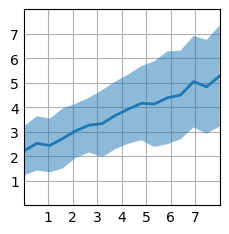

In [18]:
#MODEL
plt.style.use('_mpl-gallery')

#make data
np.random.seed(1)
x = np.linspace(0, 8, 16)
y1 = 3 + 4*x/8 + np.random.uniform(0.0, 0.5, len(x))
y2 = 1 + 2*x/8 + np.random.uniform(0.0, 0.5, len(x))

#plot
fig, ax = plt.subplots()

ax.fill_between(x, y1, y2, alpha=.5, linewidth=0)
ax.plot(x, (y1 + y2)/2, linewidth=2)

ax.set(xlim=(0, 8), xticks=np.arange(1, 8),
       ylim=(0, 8), yticks=np.arange(1, 8))

plt.show()

RASTERISATION

In [2]:
#reference image
input_fpath = 'C:/Users/Xenerios/Desktop/adv_remote-sensing/forest_class/res/ndvi/2021-02-24_ndvi.tif'
reference_img = gdal.Open(input_fpath)
geotransform = reference_img.GetGeoTransform()
print(geotransform)

spatial_resolution = geotransform[1]
xmin = geotransform[0]
ymax = geotransform[3]
xmax = xmin + geotransform[1] * reference_img.RasterXSize
ymin = ymax + geotransform[5] * reference_img.RasterYSize

(501127.9697, 10.0, 0.0, 6314464.023600001, 0.0, -10.0)


C:\Users\Xenerios\miniconda3\envs\koa4\Lib\site-packages\osgeo\gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


In [6]:
folder = 'C:/Users/Xenerios/Desktop/adv_remote-sensing/forest_class/res/samples'
ndvi_sampled = ['ndvi_lvl1', 'ndvi_lvl2', 'ndvi_lvl3']

input_vectors = 'C:/Users/Xenerios/Desktop/adv_remote-sensing/forest_class/res/Sample_BD_foret_T31TCJ/Sample_BD_foret_T31TCJ.shp'

#dictionary to map ndvi_sampled values to field names
field_name_mapping = {
    'ndvi_lvl1': 'Code_lvl1',
    'ndvi_lvl2': 'Code_lvl2',
    'ndvi_lvl3': 'Code_lvl3',
}

start = time.time()
for img in ndvi_sampled:

    #datasets
    file_name, file_extension = os.path.splitext(os.path.basename(img))
    output_fpath = os.path.join(folder, f'{file_name}.tif')

    #create empty dataset using input_dataset main properties with chosen format
    output_dataset = gdal.GetDriverByName('GTiff').Create(
        output_fpath,
        reference_img.RasterXSize,
        reference_img.RasterYSize,
        reference_img.RasterCount, #ndvi == 1 band
        gdal.GDT_Byte
    )
    
    output_dataset.SetGeoTransform(reference_img.GetGeoTransform())
    output_dataset.SetProjection(reference_img.GetProjection())
    
    #default background value
    background_value = 0
    output_dataset.GetRasterBand(1).Fill(background_value)

    #get corresponding field name from dictionary
    field_name = field_name_mapping.get(img, 'Default_Field_Name')

    print(f"Processing {img} with input vector: {input_vectors} and field name: {field_name}")
    
    #define command parameters
    cmd_pattern = ("gdal_rasterize -a {field_name} "
                   "-tr {sptial_resolution} {sptial_resolution} "
                   "-te {xmin} {ymin} {xmax} {ymax} -ot Byte -of GTiff "
                   "{in_vector} {out_image}")
    
    #set parameters
    cmd = cmd_pattern.format(in_vector=input_vectors, xmin=xmin, ymin=ymin, 
                             xmax=xmax, ymax=ymax, out_image=output_fpath, 
                             field_name=field_name,
                             sptial_resolution=spatial_resolution)

    #print command before launching
    print(f"Executing command: {cmd}")
    
    #launch command
    os.system(cmd)

    #clear output dataset
    output_dataset = None 

    time.sleep(5)  #add a small delay (e.g., 1 second)

    print(f"Rasterization completed for {img}")
    print(f"Output file path: {output_fpath}")

end = time.time()
print('processed in:', end - start)

Processing ndvi_lvl1 with input vector: C:/Users/Xenerios/Desktop/adv_remote-sensing/forest_class/res/Sample_BD_foret_T31TCJ/Sample_BD_foret_T31TCJ.shp and field name: Code_lvl1
Executing command: gdal_rasterize -a Code_lvl1 -tr 10.0 10.0 -te 501127.9697 6240654.023600001 609757.9697 6314464.023600001 -ot Byte -of GTiff C:/Users/Xenerios/Desktop/adv_remote-sensing/forest_class/res/Sample_BD_foret_T31TCJ/Sample_BD_foret_T31TCJ.shp C:/Users/Xenerios/Desktop/adv_remote-sensing/forest_class/res/samples\ndvi_lvl1.tif
Rasterization completed for ndvi_lvl1
Output file path: C:/Users/Xenerios/Desktop/adv_remote-sensing/forest_class/res/samples\ndvi_lvl1.tif
Processing ndvi_lvl2 with input vector: C:/Users/Xenerios/Desktop/adv_remote-sensing/forest_class/res/Sample_BD_foret_T31TCJ/Sample_BD_foret_T31TCJ.shp and field name: Code_lvl2
Executing command: gdal_rasterize -a Code_lvl2 -tr 10.0 10.0 -te 501127.9697 6240654.023600001 609757.9697 6314464.023600001 -ot Byte -of GTiff C:/Users/Xenerios/De

In [63]:
ndvi_maj = 'C:/Users/Xenerios/Desktop/adv_remote-sensing/forest_class/res/ndvi/maj_ndvi/maj_ndvi.tif'
filepaths = glob.glob(os.path.join(folder,'res/samples/*.tif'))

print(filepaths)

start = time.time()
for img in filepaths:

    #get samples from roi
    X, Y, t = cla.get_samples_from_roi(ndvi_maj, 
                                   img, 
                                   value_to_extract=None,
                                   bands=None, 
                                   output_fmt='by_label')

    #display ndvi mean and std values
    bands_names = ['2021-02-24', '2021-03-31', '2021-04-15', '2021-07-19', '2021-10-17', '2021-12-16']

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 5))
    
    for label, ndvi_values in X.items():
        means = np.mean(ndvi_values, axis=0)
        stds = np.std(ndvi_values, axis=0)
    
        ax.plot(means, label=f'Mean - Class {label}')
        ax.fill_between(range(len(bands_names)), means + stds, means - stds, alpha=0.3, label=f'Std Dev - Class {label}')
    
    ax.set_xticks(range(len(bands_names)))
    ax.set_xticklabels(bands_names)
    
    
    #shrink current axis by 20%
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.9, box.height])
    
    ax.set_xlabel('Bands')
    ax.set_ylabel('NDVI Values')

    #extract ndvi level from the file name
    ndvi_level = os.path.splitext(os.path.basename(img))[0]

    ax.set_title(f'Temporal Signature of Mean NDVI Values with Standard Deviation - {ndvi_level}')    
    
    #set legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    #save fig
    plt.savefig(f'temp_mean_ndvi_{ndvi_level}.png', bbox_inches='tight')  

    plt.show()

end = time.time()
print('processed in:', end - start)

processed in: 0.0009918212890625


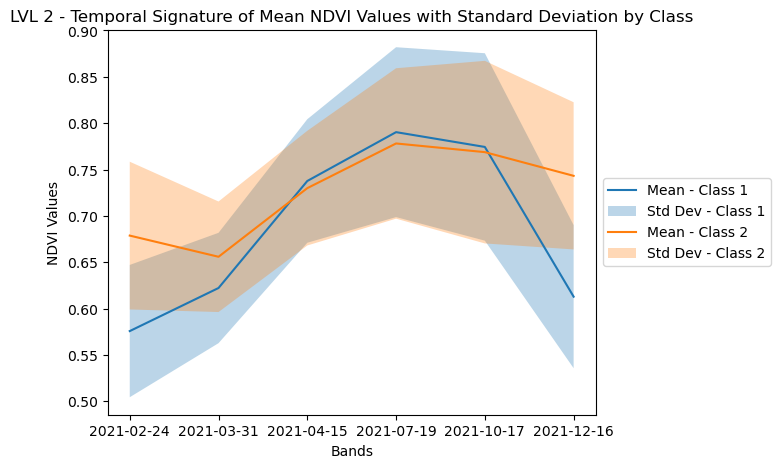

In [53]:
bands_names = ['2021-02-24', '2021-03-31', '2021-04-15', '2021-07-19', '2021-10-17', '2021-12-16']

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 5))

for label, ndvi_values in X.items():
    means = np.mean(ndvi_values, axis=0)
    stds = np.std(ndvi_values, axis=0)

    ax.plot(means, label=f'Mean - Class {label}')
    ax.fill_between(range(len(bands_names)), means + stds, means - stds, alpha=0.3, label=f'Std Dev - Class {label}')

ax.set_xticks(range(len(bands_names)))
ax.set_xticklabels(bands_names)


# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.9, box.height])



ax.set_xlabel('Bands')
ax.set_ylabel('NDVI Values')
ax.set_title('LVL 2 - Temporal Signature of Mean NDVI Values with Standard Deviation by Class')

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#ax.legend()

#save fig
plt.savefig(f'temp_mean_ndvi_lvl1.png', bbox_inches='tight') 

plt.show()

 

<Figure size 640x480 with 0 Axes>